# Week 7 - Linear classification

Learning contents:
* Least squares for classification
* Perceptron
* Logistic regression
* Extra: multi-class logistic regression

In [3]:
# Dependencies
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() # this import just makes the plots prettier
import numpy as np

## Data
We'll be working with a dataset of handwritten digits. 
Let visualise some examples.

In [4]:
# We're using a subset of two classes for now
digits = load_digits(n_class=2)

In [5]:
# Handy plotting functions
x_min, x_max = -40, 40
y_min, y_max = -40, 40

def plot_examples():
    show_num = 4
    _, axes = plt.subplots(1, show_num)
    images_and_labels = list(zip(digits.images, digits.target))
    for ax, (image, label) in zip(axes[:], images_and_labels[:show_num]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title('Label: %i' % label)

def plot_scatter(data, target, n_class=2):
    plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar();
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

def plot_decision_boundary(data, weights):
    raise NotImplementedError("You should fill this is")

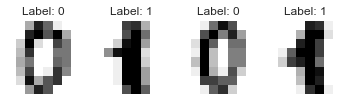

In [6]:
plot_examples()

In [7]:
# The dataset contains 2D data in the form of the `images` attribute, 
# as well as a 1D-version called `data`, where the images have been flattened. 
np.array_equal(digits.images[0].flatten(), digits.data[0])

True

In [8]:
# We can get a 2D version of the data using PCA
pca = PCA(n_components=2)
X = pca.fit_transform(digits.data) # this is the representation, we'll be working with

In [9]:
# Out targets are in the set {0,1}
t_01 = digits.target

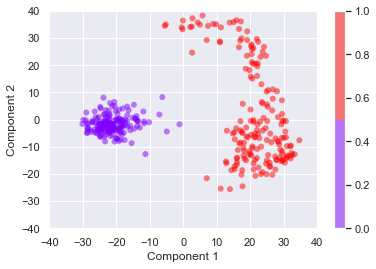

In [10]:
# Let's plot all the data in 2D
plot_scatter(X, t_01)

## 1) Least Squares

### 1.1) Find the weight vector using Least Squares for classification
Hint: Remember to augment the data with a column of 1's

In [11]:
def lsq_weight(X, t):
    w_lst = []
    
    for x in X:
        w = [1]
        for i in range(len(x)):
            w.append(x[i])
        w_lst.append(w)
    w_lst = np.array(w_lst)
    W = np.linalg.inv(w_lst.T @ w_lst) @ w_lst.T @ t

    return W

### 1.2) Create class predictions using the weight vector
You should be able to correctly classify all data

In [12]:
def prediction(X, t):
    classes = []
    W = lsq_weight(X, t)
    
    for x in X:
        x_tilde = np.array([1, x[0], x[1]])
        y = W @ x_tilde.T 
        y_thres = y - W[0] # subtracting threshold
        if y_thres >= 0:
            classes.append(1)
        else:
            classes.append(0)
            
    return classes, y

In [13]:
pred, y  = prediction(X, t_01)
np.array_equal(pred, t_01)

True

### 1.3) Plot the decision boundary 
Hint: You can do this either by plotting a line on the boundary or creating a mesh of all predictions

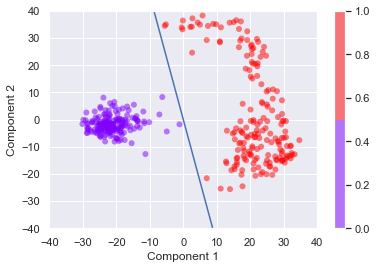

In [14]:
plot_scatter(X, t_01)
# plot_decision_boundary(X, W_least_squares)

W = lsq_weight(X, t_01)
line_x = np.linspace(-40,40)
line_y = -(W[0] + W[1] * line_x) / W[2] + W[0] / W[2] 
plt.plot(line_x, line_y)

## 2) Perceptron

A learning_rate of 0.1 should do the job.
Hint: remember to change the target representation range

In [15]:
rep_targets = [1.0 if i==0 else -1.0 for i in t_01] 

In [16]:
def perceptron(data, targets, num_iterations, learning_rate):
    
    weights = np.zeros(shape=(1, data.shape[1]+1)) 
    misclassified_total = [] 
    
    for epoch in range(num_iterations):
        c = list(zip(data, targets)) 
        np.random.shuffle(c) 
        a, b = zip(*c)
        data = np.array(a)
        targets = np.array(b)
        misclassified = 0
        
        for i,x in enumerate(data):
            x = np.insert(x,0,1)
            y = weights @ x
            target = 1.0 if (y >= 0) else -1.0
            if target != targets[i]:
                misclassified += 1
                weights += (learning_rate*x*targets[i])
        
        misclassified_total.append(misclassified)
    return (weights, misclassified_total)

num_iterations = 10
w_perceptron, misclassified_perceptron = perceptron(X, rep_targets, num_iterations, 1)

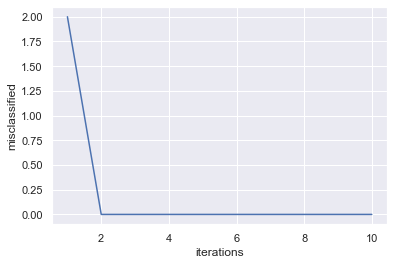

In [17]:
epochs = np.arange(1, num_iterations+1)
plt.plot(epochs, misclassified_perceptron)
plt.xlabel('iterations')
plt.ylabel('misclassified')
plt.show()

### 2.2) Perform class-predictions
Again, you should be able to classify all correctly

In [18]:
def predictions(data, weights):
    aug_data = np.hstack((np.ones(data.shape[0])[:, np.newaxis], X)) 
    y = w_perceptron @ aug_data.T 
    preds = [1 if i >= 0 else -1 for i in y[0]]
    
    return preds

preds = predictions(X, w_perceptron)
np.array_equal(preds, rep_targets)

True

### 2.3) Plot the decision boundary

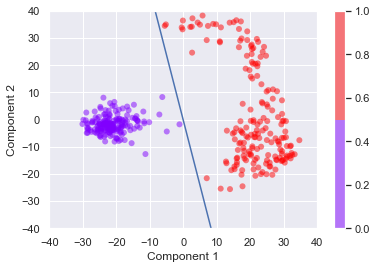

In [19]:
plot_scatter(X, t_01)
line_x = np.linspace(-40,40)
line_y = -(w_perceptron[0][0]+w_perceptron[0][1]*line_x)/w_perceptron[0][2]  
plt.plot(line_x, line_y)

## 3) Logistic Regression
### 3.1) Find the weight vector using the Logistic Regression

In [20]:
# initialise W_0 randomly
np.random.seed(42)
W_0 = 2 * np.random.random((1, 3)) -1 # random values in the range [-1,1]

# Our target vectors should be {0, 1}
t_01 = digits.target

In [21]:
def sigmoid(value):   
    a = np.exp(-value)
    return 1.0/ (1.0 + a)

### 3.2) Perform class-predictions

In [22]:
def logistic(data, targets, learning_rate, num_iterations):
    X = np.hstack((np.ones(data.shape[0])[:, np.newaxis], data)) 
    weights = 2 * np.random.random((1, X.shape[1])) -1 
    
    for epoch in range(num_iterations):   
        y = np.array(sigmoid(np.inner(weights[0], X)))
        weights[0] -= learning_rate*(X.T @ (y-targets).T)
               
    return weights

optimal_params = logistic(X, t_01, 0.1, 100)

C:\Users\Pernille\miniconda3\envs\slml\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [23]:
def predict(data, params):
    return np.round(sigmoid(data @ optimal_params[0])) # we are using probabilities

aug_data = np.hstack((np.ones(X.shape[0])[:, np.newaxis], X))
preds = predict(aug_data, optimal_params)
np.array_equal(preds, t_01)

C:\Users\Pernille\miniconda3\envs\slml\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


True

### 3.3) Plot the decision boundary

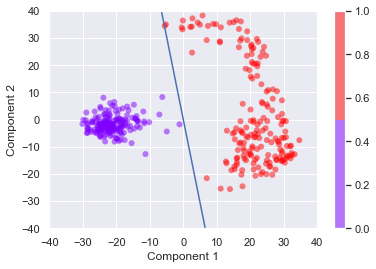

In [24]:
slope = -(optimal_params[0][1] / optimal_params[0][2])
intercept = -(optimal_params[0][0] / optimal_params[0][2])

plot_scatter(X, t_01)
line_x = np.linspace(-40,40)
line_y = intercept + (slope * line_x)
plt.plot(line_x, line_y)

## 4) Multi-class logistic regression
Repeat 3) but now for multiple classes, i.e. compute the weight matrix, perform predictions (you shold be able to get about 93% accuracy) and plot decision boundaries.

Hint: You will need to use a one-hot encoding of the targets

### I haven't made this since it says it's extra in the beginning.

## 5) Multi-class logistic regression on original data representation
Repeat exercise 4), but use the original data representation instead.
You can omit the plots.

Hint: To get 100% accuracy, you can try to:
- Rescale your data to the range [0,1]
- Run 1000 epochs with learning_rate = 0.1

### I haven't made this since it says it's extra in the beginning.